In [1]:
%load_ext autoreload
%autoreload 2


# Enfoque Experimental y Evaluación de Modelos

Con el objetivo de predecir de forma precisa si un producto listado en el marketplace es nuevo o usado, se diseñó un experimento comparativo con múltiples algoritmos de clasificación supervisada. Se seleccionaron modelos lineales, probabilísticos, basados en árboles de decisión y redes neuronales, junto con técnicas avanzadas de ingeniería de características, incluyendo embeddings generados a partir del título del producto. Todos los modelos fueron evaluados utilizando **accuracy** como métrica principal, en línea con los criterios del reto, y **F1-score** como métrica secundaria, dada su capacidad para balancear precisión y recall, especialmente relevante en escenarios donde ambos tipos de error (falsos positivos y negativos) pueden impactar la experiencia del usuario. A continuación, se detallan los resultados y hallazgos de cada modelo evaluado.


## Regresión Logística

In [57]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def build_dataset():
    # Leer el archivo JSONLines
    data = [json.loads(x) for x in open("../data/MLA_100k_checked_v3.jsonlines")]

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Seller activity
    df['seller_freq'] = df['seller_id'].map(df['seller_id'].value_counts(normalize=True))

    # Shipping info
    df['is_free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping', False) if isinstance(x, dict) else False).astype(int)
    df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', 'unknown') if isinstance(x, dict) else 'unknown')
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', False) if isinstance(x, dict) else False).astype(int)

    # Payment methods
    df['payment_method_group'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda n: n if n <= 3 else '4+')

    # Tags
    df['has_dragged_visits'] = df['tags'].apply(lambda x: 'dragged_visits' in x or 'dragged_bids_and_visits' in x if isinstance(x, list) else False).astype(int)
    df['has_good_thumbnail'] = df['tags'].apply(lambda x: 'good_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['has_poor_thumbnail'] = df['tags'].apply(lambda x: 'poor_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['was_relisted'] = df['tags'].apply(lambda x: 'free_relist' in x if isinstance(x, list) else False).astype(int)

    # Images
    df['picture_group'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-6' if x <= 6 else '7+')))

    # Title features
    df['title_length_group'] = df['title'].str.len().apply(lambda x: 'short' if x < 30 else ('medium' if x < 60 else 'long'))
    df['title_contains_new'] = df['title'].str.lower().str.contains("nuevo").fillna(False).astype(int)
    df['title_contains_used'] = df['title'].str.lower().str.contains("usado").fillna(False).astype(int)

    # Location 
    df['state_id'] = df['seller_address'].apply(lambda x: x['state']['id'] if isinstance(x, dict) else 'unknown')

    # Price diff
    df['price_diff'] = df['price'] - df['base_price']

    # Quantities
    df['sold_ratio'] = df['sold_quantity'] / (df['sold_quantity'] + df['available_quantity'] + 1e-5)
    df["availability_change"] = df["initial_quantity"] - df["available_quantity"]
    df["stock_used_ratio"] = df["availability_change"] / (df["initial_quantity"] + 1e-5)

    # Tiempos
    df["was_updated"] = (pd.to_datetime(df["last_updated"], errors="coerce") != pd.to_datetime(df["date_created"], errors="coerce")).astype(int)

    # Status
    df["is_active"] = df["status"].apply(lambda x: 1 if x == "active" else 0)

    # Columnas base
    cols_base = [
        "currency_id", "base_price", "price", "listing_type_id",
        "initial_quantity", "sold_quantity", "available_quantity", "condition",
        "seller_freq", "is_free_shipping", "shipping_mode", "local_pick_up",
        "payment_method_group", "has_dragged_visits", "has_good_thumbnail",
        "has_poor_thumbnail", "was_relisted", "picture_group", "title_length_group",
        "title_contains_new", "title_contains_used", "state_id", "price_diff",
        "sold_ratio", "availability_change", "stock_used_ratio", "was_updated",
        "is_active"
        ]

    df_model = df[cols_base].copy()

    # Target
    y = df_model["condition"]
    
    # Features: eliminamos columnas no predictivas o redundantes
    X = df_model.drop(columns=['condition'])

    # One-hot encoding para categóricas
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Codificar target
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['used', 'new'])   
    y_encoded = label_encoder.transform(y)

    # Dividir manualmente usando N = -10000
    N = -10000
    X_train = X_encoded[:N]
    X_test = X_encoded[N:]
    y_train = y_encoded[:N]
    y_test = y_encoded[N:]

    return X_train, y_train, X_test, y_test, label_encoder


In [58]:
X_train, y_train, X_test, y_test, label_encoder = build_dataset()

print("Dimensiones de los dataset:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Dimensiones de los dataset:
X_train: (90000, 63)
y_train: (90000,)
X_test: (10000, 63)
y_test: (10000,)


In [59]:
X_train


,base_price,price,initial_quantity,sold_quantity,available_quantity,seller_freq,is_free_shipping,local_pick_up,has_dragged_visits,has_good_thumbnail,...,state_id_AR-Q,state_id_AR-R,state_id_AR-S,state_id_AR-T,state_id_AR-U,state_id_AR-V,state_id_AR-W,state_id_AR-X,state_id_AR-Y,state_id_AR-Z
0,80.00,80.00,1,0,1,0.00001,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2650.00,2650.00,1,0,1,0.00003,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2,60.00,60.00,1,0,1,0.00032,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,580.00,580.00,1,0,1,0.00004,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
4,30.00,30.00,1,0,1,0.00082,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,68.00,68.00,1,0,1,0.00032,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
89996,126.00,126.00,1,1,1,0.00003,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89997,300.00,300.00,1,0,1,0.00004,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89998,696.58,696.58,100,0,100,0.00231,0,0,1,0,...,False,False,False,False,True,False,False,False,False,False


In [60]:
X_train.columns.tolist()


['base_price',
 'price',
 'initial_quantity',
 'sold_quantity',
 'available_quantity',
 'seller_freq',
 'is_free_shipping',
 'local_pick_up',
 'has_dragged_visits',
 'has_good_thumbnail',
 'has_poor_thumbnail',
 'was_relisted',
 'title_contains_new',
 'title_contains_used',
 'price_diff',
 'sold_ratio',
 'availability_change',
 'stock_used_ratio',
 'was_updated',
 'is_active',
 'currency_id_USD',
 'listing_type_id_free',
 'listing_type_id_gold',
 'listing_type_id_gold_premium',
 'listing_type_id_gold_pro',
 'listing_type_id_gold_special',
 'listing_type_id_silver',
 'shipping_mode_me1',
 'shipping_mode_me2',
 'shipping_mode_not_specified',
 'payment_method_group_1',
 'payment_method_group_2',
 'payment_method_group_3',
 'payment_method_group_4+',
 'picture_group_1',
 'picture_group_2-6',
 'picture_group_7+',
 'title_length_group_medium',
 'title_length_group_short',
 'state_id_AR-A',
 'state_id_AR-B',
 'state_id_AR-C',
 'state_id_AR-D',
 'state_id_AR-E',
 'state_id_AR-F',
 'state_id_AR

In [61]:
y_train


array([1, 0, 0, ..., 1, 1, 0])

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Escalamos los datos numéricos manualmente
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creamos y entrenamos el modelo
logreg = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predicciones
y_pred = logreg.predict(X_test_scaled)

# Evaluación
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Evaluación
print(f"Accuracy: {acc:.4f} {'Cumple' if acc >= 0.86 else 'No cumple'}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7783 No cumple
F1-score: 0.7988

Classification Report:
               precision    recall  f1-score   support

        used       0.77      0.74      0.75      4594
         new       0.78      0.81      0.80      5406

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



El modelo de regresión logística alcanzó una precisión (**Accuracy**) de **0.7783**, por debajo del umbral mínimo requerido (0.86). Sin embargo, mostró un desempeño razonable en términos de **F1-score** (**0.7988**), lo que evidencia un buen equilibrio entre *precisión* y *recall* al clasificar productos como nuevos o usados.


In [64]:
# Obtener los coeficientes
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': logreg.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(coef_df.head(10))      # Top 10 que empujan hacia clase 1 (new)
print(coef_df.tail(10))      # Top 10 que empujan hacia clase 0 (used)


                         feature  coefficient
4             available_quantity     6.144394
2               initial_quantity     6.131391
3                  sold_quantity     3.929998
15                    sold_ratio     0.619994
25  listing_type_id_gold_special     0.467602
12            title_contains_new     0.382194
6               is_free_shipping     0.343326
35             picture_group_2-6     0.246368
17              stock_used_ratio     0.217638
27             shipping_mode_me1     0.207452
                         feature  coefficient
33       payment_method_group_4+    -0.092868
30        payment_method_group_1    -0.095480
23  listing_type_id_gold_premium    -0.095876
29   shipping_mode_not_specified    -0.140325
11                  was_relisted    -0.142900
28             shipping_mode_me2    -0.222273
13           title_contains_used    -0.318087
8             has_dragged_visits    -0.378401
16           availability_change    -0.838136
21          listing_type_id_free  

Desde una perspectiva interpretativa, el modelo se comporta de forma coherente con las dinámicas del marketplace. Variables como `available_quantity`, `initial_quantity` y `sold_quantity` tienen coeficientes positivos fuertes, reflejando que los ítems nuevos suelen tener mayor volumen de stock y ventas. Por otro lado, `title_contains_used`, `availability_change` y `listing_type_id_free` presentan coeficientes negativos, alineándose con características más comunes en productos usados.

Por último, si bien este modelo ofrece buena interpretabilidad y una base sólida para benchmarking, no alcanza el rendimiento necesario para ser considerado.

## Modelo Naive Bayes

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def build_dataset():
    # Leer el archivo JSONLines
    data = [json.loads(x) for x in open("../data/MLA_100k_checked_v3.jsonlines")]

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Seller activity
    df['seller_freq'] = df['seller_id'].map(df['seller_id'].value_counts(normalize=True))

    # Shipping info
    df['is_free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping', False) if isinstance(x, dict) else False).astype(int)
    df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', 'unknown') if isinstance(x, dict) else 'unknown')
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', False) if isinstance(x, dict) else False).astype(int)

    # Payment methods
    df['payment_method_group'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda n: n if n <= 3 else '4+')

    # Tags
    df['has_dragged_visits'] = df['tags'].apply(lambda x: 'dragged_visits' in x or 'dragged_bids_and_visits' in x if isinstance(x, list) else False).astype(int)
    df['has_good_thumbnail'] = df['tags'].apply(lambda x: 'good_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['has_poor_thumbnail'] = df['tags'].apply(lambda x: 'poor_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['was_relisted'] = df['tags'].apply(lambda x: 'free_relist' in x if isinstance(x, list) else False).astype(int)

    # Images
    df['picture_group'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-6' if x <= 6 else '7+')))

    # Title features
    df['title_length_group'] = df['title'].str.len().apply(lambda x: 'short' if x < 30 else ('medium' if x < 60 else 'long'))
    df['title_contains_new'] = df['title'].str.lower().str.contains("nuevo").fillna(False).astype(int)
    df['title_contains_used'] = df['title'].str.lower().str.contains("usado").fillna(False).astype(int)

    # Location 
    df['state_id'] = df['seller_address'].apply(lambda x: x['state']['id'] if isinstance(x, dict) else 'unknown')

    # Price diff
    df['price_diff'] = df['price'] - df['base_price']

    # Quantities
    df['sold_ratio'] = df['sold_quantity'] / (df['sold_quantity'] + df['available_quantity'] + 1e-5)
    df["availability_change"] = df["initial_quantity"] - df["available_quantity"]
    df["stock_used_ratio"] = df["availability_change"] / (df["initial_quantity"] + 1e-5)

    # Tiempos
    df["was_updated"] = (pd.to_datetime(df["last_updated"], errors="coerce") != pd.to_datetime(df["date_created"], errors="coerce")).astype(int)

    # Status
    df["is_active"] = df["status"].apply(lambda x: 1 if x == "active" else 0)

    # Columnas base
    cols_base = [
        "currency_id", "base_price", "price", "listing_type_id",
        "initial_quantity", "sold_quantity", "available_quantity", "condition",
        "seller_freq", "is_free_shipping", "shipping_mode", "local_pick_up",
        "payment_method_group", "has_dragged_visits", "has_good_thumbnail",
        "has_poor_thumbnail", "was_relisted", "picture_group", "title_length_group",
        "title_contains_new", "title_contains_used", "state_id", "price_diff",
        "sold_ratio", "availability_change", "stock_used_ratio", "was_updated",
        "is_active"
        ]

    df_model = df[cols_base].copy()

    # Target
    y = df_model["condition"]
    
    # Features: eliminamos columnas no predictivas o redundantes
    X = df_model.drop(columns=['condition'])

    # One-hot encoding para categóricas
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Codificar target
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['used', 'new'])   
    y_encoded = label_encoder.transform(y)

    # Dividir manualmente usando N = -10000
    N = -10000
    X_train = X_encoded[:N]
    X_test = X_encoded[N:]
    y_train = y_encoded[:N]
    y_test = y_encoded[N:]

    return X_train, y_train, X_test, y_test, label_encoder


In [3]:
X_train, y_train, X_test, y_test, label_encoder = build_dataset()

print("Dimensiones de los dataset:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Dimensiones de los dataset:
X_train: (90000, 63)
y_train: (90000,)
X_test: (10000, 63)
y_test: (10000,)


In [4]:
X_train


,base_price,price,initial_quantity,sold_quantity,available_quantity,seller_freq,is_free_shipping,local_pick_up,has_dragged_visits,has_good_thumbnail,...,state_id_AR-Q,state_id_AR-R,state_id_AR-S,state_id_AR-T,state_id_AR-U,state_id_AR-V,state_id_AR-W,state_id_AR-X,state_id_AR-Y,state_id_AR-Z
0,80.00,80.00,1,0,1,0.00001,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2650.00,2650.00,1,0,1,0.00003,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2,60.00,60.00,1,0,1,0.00032,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,580.00,580.00,1,0,1,0.00004,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
4,30.00,30.00,1,0,1,0.00082,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,68.00,68.00,1,0,1,0.00032,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
89996,126.00,126.00,1,1,1,0.00003,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89997,300.00,300.00,1,0,1,0.00004,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89998,696.58,696.58,100,0,100,0.00231,0,0,1,0,...,False,False,False,False,True,False,False,False,False,False


In [5]:
X_train.columns.tolist()

['base_price',
 'price',
 'initial_quantity',
 'sold_quantity',
 'available_quantity',
 'seller_freq',
 'is_free_shipping',
 'local_pick_up',
 'has_dragged_visits',
 'has_good_thumbnail',
 'has_poor_thumbnail',
 'was_relisted',
 'title_contains_new',
 'title_contains_used',
 'price_diff',
 'sold_ratio',
 'availability_change',
 'stock_used_ratio',
 'was_updated',
 'is_active',
 'currency_id_USD',
 'listing_type_id_free',
 'listing_type_id_gold',
 'listing_type_id_gold_premium',
 'listing_type_id_gold_pro',
 'listing_type_id_gold_special',
 'listing_type_id_silver',
 'shipping_mode_me1',
 'shipping_mode_me2',
 'shipping_mode_not_specified',
 'payment_method_group_1',
 'payment_method_group_2',
 'payment_method_group_3',
 'payment_method_group_4+',
 'picture_group_1',
 'picture_group_2-6',
 'picture_group_7+',
 'title_length_group_medium',
 'title_length_group_short',
 'state_id_AR-A',
 'state_id_AR-B',
 'state_id_AR-C',
 'state_id_AR-D',
 'state_id_AR-E',
 'state_id_AR-F',
 'state_id_AR

In [6]:
y_train


array([1, 0, 0, ..., 1, 1, 0])

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Entrenar y predecir
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Evaluación
print(f"Accuracy: {acc:.4f} {'Cumple' if acc >= 0.86 else 'No cumple'}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.4741 No cumple
F1-score: 0.0529

Classification Report:
               precision    recall  f1-score   support

        used       0.47      1.00      0.64      4594
         new       1.00      0.03      0.05      5406

    accuracy                           0.47     10000
   macro avg       0.73      0.51      0.34     10000
weighted avg       0.75      0.47      0.32     10000



El modelo de Naive Bayes obtuvo un **Accuracy** de **0.4741** y un **F1-score** de **0.0529**, lo que indica un desempeño deficiente para el reto propuesto. A pesar de que predice correctamente casi todos los productos usados, falla casi por completo en identificar productos nuevos, evidenciado por un recall de apenas **0.03** en esa clase.

En este contexto, Naive Bayes no es adecuado para capturar la complejidad de los datos del marketplace, posiblemente debido a sus fuertes supuestos de independencia entre variables.


## Modelos basados en árboles

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def build_dataset():
    # Leer el archivo JSONLines
    data = [json.loads(x) for x in open("../data/MLA_100k_checked_v3.jsonlines")]

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Seller activity
    df['seller_freq'] = df['seller_id'].map(df['seller_id'].value_counts(normalize=True))

    # Shipping info
    df['is_free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping', False) if isinstance(x, dict) else False).astype(int)
    df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', 'unknown') if isinstance(x, dict) else 'unknown')
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', False) if isinstance(x, dict) else False).astype(int)

    # Payment methods
    df['payment_method_group'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda n: n if n <= 3 else '4+')

    # Tags
    df['has_dragged_visits'] = df['tags'].apply(lambda x: 'dragged_visits' in x or 'dragged_bids_and_visits' in x if isinstance(x, list) else False).astype(int)
    df['has_good_thumbnail'] = df['tags'].apply(lambda x: 'good_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['has_poor_thumbnail'] = df['tags'].apply(lambda x: 'poor_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['was_relisted'] = df['tags'].apply(lambda x: 'free_relist' in x if isinstance(x, list) else False).astype(int)

    # Images
    df['picture_group'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-6' if x <= 6 else '7+')))

    # Title features
    df['title_length_group'] = df['title'].str.len().apply(lambda x: 'short' if x < 30 else ('medium' if x < 60 else 'long'))
    df['title_contains_new'] = df['title'].str.lower().str.contains("nuevo").fillna(False).astype(int)
    df['title_contains_used'] = df['title'].str.lower().str.contains("usado").fillna(False).astype(int)

    # Location 
    df['state_id'] = df['seller_address'].apply(lambda x: x['state']['id'] if isinstance(x, dict) else 'unknown')

    # Price diff
    df['price_diff'] = df['price'] - df['base_price']

    # Quantities
    df['sold_ratio'] = df['sold_quantity'] / (df['sold_quantity'] + df['available_quantity'] + 1e-5)
    df["availability_change"] = df["initial_quantity"] - df["available_quantity"]
    df["stock_used_ratio"] = df["availability_change"] / (df["initial_quantity"] + 1e-5)

    # Tiempos
    df["was_updated"] = (pd.to_datetime(df["last_updated"], errors="coerce") != pd.to_datetime(df["date_created"], errors="coerce")).astype(int)

    # Status
    df["is_active"] = df["status"].apply(lambda x: 1 if x == "active" else 0)

    # Columnas base
    cols_base = [
        "currency_id", "base_price", "price", "listing_type_id",
        "initial_quantity", "sold_quantity", "available_quantity", "condition",
        "seller_freq", "is_free_shipping", "shipping_mode", "local_pick_up",
        "payment_method_group", "has_dragged_visits", "has_good_thumbnail",
        "has_poor_thumbnail", "was_relisted", "picture_group", "title_length_group",
        "title_contains_new", "title_contains_used", "state_id", "price_diff",
        "sold_ratio", "availability_change", "stock_used_ratio", "was_updated",
        "is_active"
        ]

    df_model = df[cols_base].copy()

    # Target
    y = df_model["condition"]
    
    # Features: eliminamos columnas no predictivas o redundantes
    X = df_model.drop(columns=['condition'])

    # One-hot encoding para categóricas
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Codificar target
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['used', 'new'])   
    y_encoded = label_encoder.transform(y)

    # Dividir manualmente usando N = -10000
    N = -10000
    X_train = X_encoded[:N]
    X_test = X_encoded[N:]
    y_train = y_encoded[:N]
    y_test = y_encoded[N:]

    return X_train, y_train, X_test, y_test, label_encoder


In [4]:
X_train, y_train, X_test, y_test, label_encoder = build_dataset()

print("Dimensiones de los dataset:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Dimensiones de los dataset:
X_train: (90000, 63)
y_train: (90000,)
X_test: (10000, 63)
y_test: (10000,)


In [74]:
X_train


,base_price,price,initial_quantity,sold_quantity,available_quantity,seller_freq,is_free_shipping,local_pick_up,has_dragged_visits,has_good_thumbnail,...,state_id_AR-Q,state_id_AR-R,state_id_AR-S,state_id_AR-T,state_id_AR-U,state_id_AR-V,state_id_AR-W,state_id_AR-X,state_id_AR-Y,state_id_AR-Z
0,80.00,80.00,1,0,1,0.00001,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2650.00,2650.00,1,0,1,0.00003,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2,60.00,60.00,1,0,1,0.00032,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
3,580.00,580.00,1,0,1,0.00004,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
4,30.00,30.00,1,0,1,0.00082,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,68.00,68.00,1,0,1,0.00032,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
89996,126.00,126.00,1,1,1,0.00003,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89997,300.00,300.00,1,0,1,0.00004,0,1,1,0,...,False,False,False,False,False,False,False,False,False,False
89998,696.58,696.58,100,0,100,0.00231,0,0,1,0,...,False,False,False,False,True,False,False,False,False,False


In [75]:
X_train.columns.tolist()


['base_price',
 'price',
 'initial_quantity',
 'sold_quantity',
 'available_quantity',
 'seller_freq',
 'is_free_shipping',
 'local_pick_up',
 'has_dragged_visits',
 'has_good_thumbnail',
 'has_poor_thumbnail',
 'was_relisted',
 'title_contains_new',
 'title_contains_used',
 'price_diff',
 'sold_ratio',
 'availability_change',
 'stock_used_ratio',
 'was_updated',
 'is_active',
 'currency_id_USD',
 'listing_type_id_free',
 'listing_type_id_gold',
 'listing_type_id_gold_premium',
 'listing_type_id_gold_pro',
 'listing_type_id_gold_special',
 'listing_type_id_silver',
 'shipping_mode_me1',
 'shipping_mode_me2',
 'shipping_mode_not_specified',
 'payment_method_group_1',
 'payment_method_group_2',
 'payment_method_group_3',
 'payment_method_group_4+',
 'picture_group_1',
 'picture_group_2-6',
 'picture_group_7+',
 'title_length_group_medium',
 'title_length_group_short',
 'state_id_AR-A',
 'state_id_AR-B',
 'state_id_AR-C',
 'state_id_AR-D',
 'state_id_AR-E',
 'state_id_AR-F',
 'state_id_AR

In [76]:
y_train


array([1, 0, 0, ..., 1, 1, 0])

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar y predecir
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
from xgboost import XGBClassifier

# Entrenar y predecir
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Usamos StratifiedKFold para mantener proporciones de clases
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Definir el espacio de búsqueda para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
}

# Crear el objeto GridSearchCV
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con GridSearchCV
grid_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Best RF Params:", grid_rf.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/leo/.cache/pypoetry/virtualenvs/itemclassifier-DdLaaTw2-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF Params: {'max_depth': 40, 'min_samples_split': 10, 'n_estimators': 200}


In [17]:
from xgboost import XGBClassifier

# Definir el espacio de búsqueda para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 12],
    'learning_rate': [0.1, 0.3, 0.6],
    'subsample': [0.4, 0.8, 1.0],
}

# Crear el objeto GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con GridSearchCV
grid_xgb.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Best XGBoost Params:", grid_xgb.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300, 'subsample': 0.8}


In [18]:
from catboost import CatBoostClassifier

# Definir el espacio de hiperparámetros para CatBoost
param_grid_cat = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.03, 0.1, 0.5],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

# Configurar GridSearchCV para CatBoost
grid_cat = GridSearchCV(
    estimator=CatBoostClassifier(random_state=42, verbose=0),
    param_grid=param_grid_cat,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo con GridSearchCV
grid_cat.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Best CatBoost Params:", grid_cat.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/leo/.cache/pypoetry/virtualenvs/itemclassifier-DdLaaTw2-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best CatBoost Params: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.5}


In [20]:
from sklearn.ensemble import VotingClassifier

# Crear un clasificador de votación
voting_clf = VotingClassifier(estimators=[
    ('rf', grid_rf.best_estimator_),
    ('xgb', grid_xgb.best_estimator_),
    ('cat', grid_cat.best_estimator_)
], voting='soft')

# Entrenar el clasificador de votación
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=40,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=Non...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fbf8f341010>)],
                 voting='soft')

In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Función para evaluar el modelo
def evaluar_modelo(nombre, modelo, X_test, y_test, cumple_umbral=0.86):
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n Resultados de {nombre}:")
    print(f"Accuracy: {acc:.4f} {'(Cumple)' if acc >= cumple_umbral else '(No cumple)'}")
    print(f"F1-score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


# Modelos simples (entrenados sobre X_train completo)
evaluar_modelo("Random Forest Simple", rf, X_test, y_test)
evaluar_modelo("XGBoost Simple", xgb, X_test, y_test)

# Modelos entrenados sobre X_train_selected
evaluar_modelo("Random Forest", grid_rf.best_estimator_, X_test, y_test)
evaluar_modelo("XGBoost", grid_xgb.best_estimator_, X_test, y_test)
evaluar_modelo("CatBoost"   , grid_cat.best_estimator_, X_test, y_test)
evaluar_modelo("Voting Ensemble", voting_clf, X_test, y_test)



 Resultados de Random Forest Simple:
Accuracy: 0.8603 (Cumple)
F1-score: 0.8704
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4594
           1       0.87      0.87      0.87      5406

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


 Resultados de XGBoost Simple:
Accuracy: 0.8771 (Cumple)
F1-score: 0.8851
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4594
           1       0.89      0.88      0.89      5406

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


 Resultados de Random Forest:
Accuracy: 0.8692 (Cumple)
F1-score: 0.8775
Classification Report:
              precision    recall  f1-score   s

Entre los modelos evaluados, los basados en árboles demostraron un rendimiento notable, superando consistentemente el umbral mínimo de precisión del 86%. El modelo de **XGBoost ajustado** se destacó con un **accuracy de 0.8832** y un **F1-score de 0.8907**, posicionándose como la mejor opción al combinar alta capacidad de generalización con un excelente equilibrio entre precisión y recall. Otros modelos como **CatBoost** y el **Voting Ensemble** ofrecieron resultados competitivos, confirmando la eficacia de los enfoques avanzados para capturar patrones complejos en los datos del marketplace.


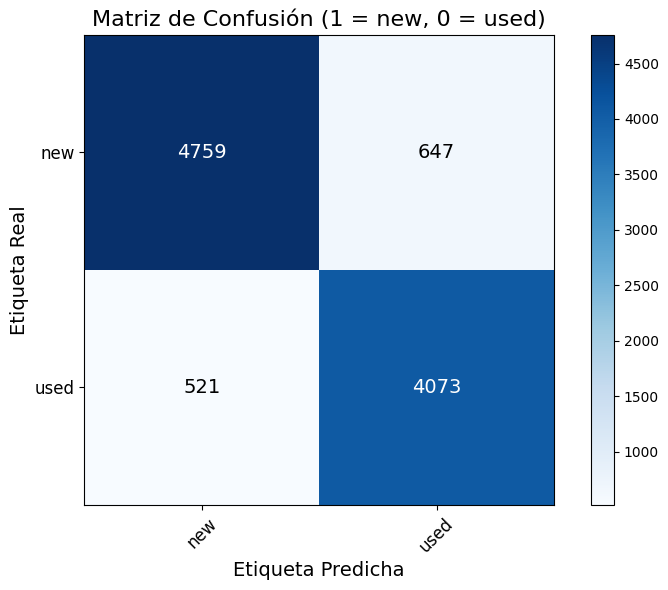

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Etiquetas invertidas: new primero
labels = [1, 0]  # 1 = new, 0 = used
display_labels = ["new", "used"]

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualización
plt.figure(figsize=(8, 6))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Matriz de Confusión (1 = new, 0 = used)', fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(display_labels))
plt.xticks(tick_marks, display_labels, rotation=45, fontsize=12)
plt.yticks(tick_marks, display_labels, fontsize=12)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}',
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.ylabel('Etiqueta Real', fontsize=14)
plt.xlabel('Etiqueta Predicha', fontsize=14)
plt.tight_layout()
plt.show()


De esta manera, el modelo de XGBoost no solo cumple con los requisitos técnicos del reto, sino que también entrega una solución robusta y alineada con el dinamismo del entorno transaccional del marketplace. Su desempeño fue respaldado por la **matriz de confusión**, que evidenció **4073 verdaderos negativos** y **4759 verdaderos positivos**, frente a **521 falsos positivos** y **647 falsos negativos**. Estos resultados se traducen en una *accuracy* cercana al **88.3%** y un **F1-score** consistente, reflejando un adecuado balance entre precisión y sensibilidad en la clasificación de ítems.

Sin embargo, la ligera preponderancia de falsos negativos sobre los falsos positivos sugiere una oportunidad de mejora, especialmente en contextos donde la detección precisa de la clase positiva es prioritaria. En tales escenarios, ajustar el umbral de decisión podría permitir un mayor control del trade-off entre precisión y recall, optimizando aún más el desempeño del sistema según los objetivos específicos del negocio.

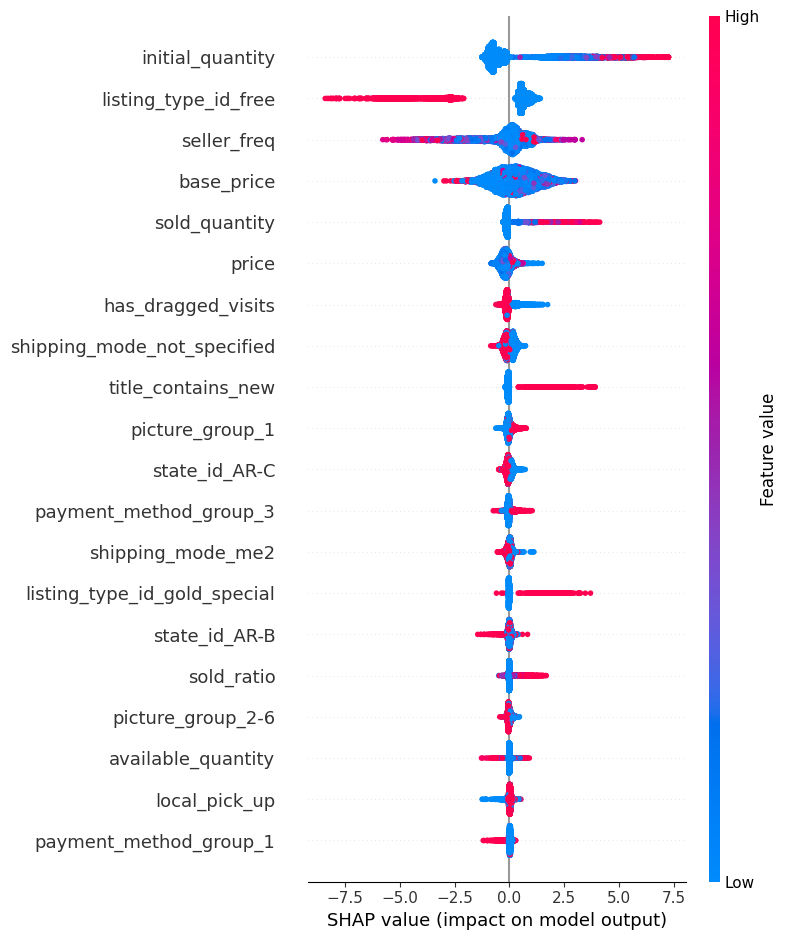

In [71]:
import shap
import matplotlib.pyplot as plt

# Obtener el mejor modelo
best_xgb_model = grid_xgb.best_estimator_

# Crear un objeto explainer SHAP 
explainer = shap.TreeExplainer(best_xgb_model)

# Calcular los valores SHAP sobre el conjunto de evaluación final
shap_values = explainer.shap_values(X_test)

# Visualizar los valores SHAP (resumen de importancia global de las variables)
shap.summary_plot(shap_values, X_test)


El análisis de valores SHAP muestra que `initial_quantity` es la variable más influyente en las predicciones del modelo, donde valores altos (en rojo) tienden a desplazar las predicciones hacia la clase “nuevo”, indicando que productos listados inicialmente en grandes cantidades suelen ser nuevos. Atributos como `listing_type_id_free` y `seller_freq` también tienen alto impacto: sus valores altos empujan fuertemente hacia la clase “usado”, lo que sugiere que publicaciones gratuitas y vendedores con alta frecuencia están asociados a productos reutilizados. Variables como `base_price`, `sold_quantity` y `title_contains_new` tienen un efecto positivo en la predicción de productos nuevos, evidenciando que tanto señales semánticas como transaccionales son captadas por el modelo. En conjunto, los SHAP values confirman que el modelo aprende patrones coherentes con el comportamiento real de publicación y consumo en el entorno del marketplace.


In [ ]:
import os
import joblib

# Crear carpeta si no existe
output_dir = "../models/tree-based"
os.makedirs(output_dir, exist_ok=True)

# Guardar modelos
joblib.dump(grid_rf.best_estimator_, os.path.join(output_dir, "random_forest.pkl"))
joblib.dump(grid_xgb.best_estimator_, os.path.join(output_dir, "xgboost.pkl"))
joblib.dump(grid_cat.best_estimator_, os.path.join(output_dir, "catboost.pkl"))
joblib.dump(voting_clf, os.path.join(output_dir, "voting_ensemble.pkl"))

# Guardar el encoder
joblib.dump(label_encoder, os.path.join(output_dir, "label_encoder.pkl"))

print("Modelos y encoder guardados exitosamente en 'tree-based/'")


Modelos y encoder guardados exitosamente en 'tree-based/'


# Redes Neuronales

In [45]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def build_dataset():
    filepath = "../data/MLA_100k_checked_v3.jsonlines"
    with open(filepath) as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)

    # Seller activity
    df['seller_freq'] = df['seller_id'].map(df['seller_id'].value_counts(normalize=True))

    # Shipping info
    df['is_free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping', False) if isinstance(x, dict) else False).astype(int)
    df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', 'unknown') if isinstance(x, dict) else 'unknown')
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', False) if isinstance(x, dict) else False).astype(int)

    # Payment methods
    df['payment_method_group'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda n: n if n <= 3 else '4+')

    # Tags
    df['has_dragged_visits'] = df['tags'].apply(lambda x: 'dragged_visits' in x or 'dragged_bids_and_visits' in x if isinstance(x, list) else False).astype(int)
    df['has_good_thumbnail'] = df['tags'].apply(lambda x: 'good_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['has_poor_thumbnail'] = df['tags'].apply(lambda x: 'poor_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['was_relisted'] = df['tags'].apply(lambda x: 'free_relist' in x if isinstance(x, list) else False).astype(int)

    # Images
    df['picture_group'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-6' if x <= 6 else '7+')))

    # Title features
    df['title_length_group'] = df['title'].str.len().apply(lambda x: 'short' if x < 30 else ('medium' if x < 60 else 'long'))
    df['title_contains_new'] = df['title'].str.lower().str.contains("nuevo").fillna(False).astype(int)
    df['title_contains_used'] = df['title'].str.lower().str.contains("usado").fillna(False).astype(int)

    # Location 
    df['state_id'] = df['seller_address'].apply(lambda x: x['state']['id'] if isinstance(x, dict) else 'unknown')

    # Price diff
    df['price_diff'] = df['price'] - df['base_price']

    # Quantities
    df['sold_ratio'] = df['sold_quantity'] / (df['sold_quantity'] + df['available_quantity'] + 1e-5)
    df['availability_change'] = df['initial_quantity'] - df['available_quantity']
    df['stock_used_ratio'] = df['availability_change'] / (df['initial_quantity'] + 1e-5)

    # Tiempos
    df['was_updated'] = (pd.to_datetime(df['last_updated'], errors='coerce') != pd.to_datetime(df['date_created'], errors='coerce')).astype(int)

    # Status
    df['is_active'] = df['status'].apply(lambda x: 1 if x == 'active' else 0)

    # Columnas base
    cols_base = [
        "currency_id", "base_price", "price", "listing_type_id",
        "initial_quantity", "sold_quantity", "available_quantity", "condition",
        "seller_freq", "is_free_shipping", "shipping_mode", "local_pick_up",
        "payment_method_group", "has_dragged_visits", "has_good_thumbnail",
        "has_poor_thumbnail", "was_relisted", "picture_group", "title_length_group",
        "title_contains_new", "title_contains_used", "state_id", "price_diff",
        "sold_ratio", "availability_change", "stock_used_ratio", "was_updated",
        "is_active"
    ]
    
    df_model = df[cols_base].copy()

    # Target
    y = df_model["condition"]
    X = df_model.drop(columns=["condition"])

    # One-hot encoding
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Escalar características numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # Codificar target 
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['used', 'new'])  # 0 = used, 1 = new
    y_encoded = label_encoder.transform(y)

    # División manual
    N = -10000
    X_train = X_scaled[:N]
    X_test = X_scaled[N:]
    y_train = y_encoded[:N]
    y_test = y_encoded[N:]

    return X_train, y_train, X_test, y_test, label_encoder


In [46]:
X_train, y_train, X_test, y_test, label_encoder = build_dataset()

print("Dimensiones de los dataset:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Dimensiones de los dataset:
X_train: (90000, 63)
y_train: (90000,)
X_test: (10000, 63)
y_test: (10000,)


In [47]:
y_train.shape


(90000,)

In [48]:
import datetime
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Red neuronal para clasificación binaria
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               8192      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16513 (64.50 KB)
Trainable params: 16513 (64.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, tensorboard_callback]
)


Epoch 1/150
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4695 - accuracy: 0.7650 - val_loss: 0.4239 - val_accuracy: 0.7978
Epoch 2/150
1125/1125 [==============================] - 3s 2ms/step - loss: 0.4284 - accuracy: 0.7934 - val_loss: 0.4138 - val_accuracy: 0.8066
Epoch 3/150
1125/1125 [==============================] - 3s 2ms/step - loss: 0.4167 - accuracy: 0.7995 - val_loss: 0.4067 - val_accuracy: 0.8104
Epoch 4/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4091 - accuracy: 0.8039 - val_loss: 0.3990 - val_accuracy: 0.8136
Epoch 5/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4032 - accuracy: 0.8059 - val_loss: 0.3944 - val_accuracy: 0.8138
Epoch 6/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3985 - accuracy: 0.8097 - val_loss: 0.3886 - val_accuracy: 0.8179
Epoch 7/150
1125/1125 [==============================] - 3s 2ms/step - loss: 0.3947 - accuracy: 0.8107 - val_loss: 0.3837 - val_ac

In [50]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {accuracy:.4f}")

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Accuracy y F1-score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f} {'Cumple' if acc >= 0.86 else 'No cumple'}")
print(f"F1-score: {f1:.4f}")

# Reporte completo
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8349
313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8349 No cumple
F1-score: 0.8493

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      4594
           1       0.84      0.86      0.85      5406

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



La red neuronal profunda entrenada alcanzó un **accuracy de 0.8349**, quedando ligeramente por debajo del umbral mínimo establecido (0.86). Sin embargo, logró un **F1-score de 0.8493**, lo que refleja un buen equilibrio entre precisión y recall, especialmente en la clase “nuevo” donde el modelo alcanzó un recall del 86%. La arquitectura, compuesta por dos capas ocultas densas (128 y 64 neuronas respectivamente) y regularización mediante Dropout, demostró ser eficaz para capturar patrones no lineales en datos tabulares. Aunque el modelo es competitivo frente a los baselines, su rendimiento es inferior al de modelos tree-based como XGBoost, lo que sugiere que en este caso, las relaciones jerárquicas y las variables categóricas son mejor explotadas por algoritmos de ensamblado que por arquitecturas densas tradicionales.


# Redes Neuronales con Embeddings

En este experimento, se implementó una arquitectura de red neuronal feedforward con el objetivo de integrar señales estructurales y semánticas para la predicción de la condición del producto (nuevo o usado) en el marketplace. Para enriquecer la representación textual del título del producto, se utilizaron **embeddings generados con el modelo multilingüe DistilUSE de Sentence-BERT**, los cuales fueron posteriormente reducidos a 50 dimensiones utilizando **UMAP** con el fin de preservar la estructura semántica relevante minimizando la complejidad del modelo. Estos vectores comprimidos se combinaron con variables tabulares tradicionales (precio, cantidad, tipo de publicación, entre otras), generando un conjunto de datos híbrido escalado y codificado que alimentó la red neuronal. Esta configuración buscó capturar tanto patrones transaccionales como el contenido semántico de los títulos, permitiendo al modelo aprender relaciones complejas entre la información textual y estructurada.


In [51]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import numpy as np
import re
from umap import UMAP
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sentence_transformers import SentenceTransformer

def extract_sbert_features(df, model_name='distiluse-base-multilingual-cased-v2', n_components=50, random_state=42):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(df['title'].fillna(""), show_progress_bar=True)

    umap = UMAP(n_components=n_components, random_state=random_state)
    reduced_embeddings = umap.fit_transform(embeddings)

    embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f"sbert_{i}" for i in range(reduced_embeddings.shape[1])])
    embeddings_df.index = df.index
    df = pd.concat([df, embeddings_df], axis=1)

    print(f"[SBERT] UMAP redujo las dimensiones a {n_components} componentes.")
    return df

def build_dataset():
    filepath = "../data/MLA_100k_checked_v3.jsonlines"
    with open(filepath) as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)

    # Seller activity
    df['seller_freq'] = df['seller_id'].map(df['seller_id'].value_counts(normalize=True))

    # Shipping info
    df['is_free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping', False) if isinstance(x, dict) else False).astype(int)
    df['shipping_mode'] = df['shipping'].apply(lambda x: x.get('mode', 'unknown') if isinstance(x, dict) else 'unknown')
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up', False) if isinstance(x, dict) else False).astype(int)

    # Payment methods
    df['payment_method_group'] = df['non_mercado_pago_payment_methods'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(lambda n: n if n <= 3 else '4+')

    # Tags
    df['has_dragged_visits'] = df['tags'].apply(lambda x: 'dragged_visits' in x or 'dragged_bids_and_visits' in x if isinstance(x, list) else False).astype(int)
    df['has_good_thumbnail'] = df['tags'].apply(lambda x: 'good_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['has_poor_thumbnail'] = df['tags'].apply(lambda x: 'poor_quality_thumbnail' in x if isinstance(x, list) else False).astype(int)
    df['was_relisted'] = df['tags'].apply(lambda x: 'free_relist' in x if isinstance(x, list) else False).astype(int)

    # Images
    df['picture_group'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).apply(
        lambda x: '0' if x == 0 else ('1' if x == 1 else ('2-6' if x <= 6 else '7+')))

    # Title features
    df['title_length_group'] = df['title'].str.len().apply(lambda x: 'short' if x < 30 else ('medium' if x < 60 else 'long'))
    df['title_contains_new'] = df['title'].str.lower().str.contains("nuevo").fillna(False).astype(int)
    df['title_contains_used'] = df['title'].str.lower().str.contains("usado").fillna(False).astype(int)

    # Location 
    df['state_id'] = df['seller_address'].apply(lambda x: x['state']['id'] if isinstance(x, dict) else 'unknown')

    # Price diff
    df['price_diff'] = df['price'] - df['base_price']

    # Quantities
    df['sold_ratio'] = df['sold_quantity'] / (df['sold_quantity'] + df['available_quantity'] + 1e-5)
    df['availability_change'] = df['initial_quantity'] - df['available_quantity']
    df['stock_used_ratio'] = df['availability_change'] / (df['initial_quantity'] + 1e-5)

    # Tiempos
    df['was_updated'] = (pd.to_datetime(df['last_updated'], errors='coerce') != pd.to_datetime(df['date_created'], errors='coerce')).astype(int)

    # Status
    df['is_active'] = df['status'].apply(lambda x: 1 if x == 'active' else 0)

    # SBERT + UMAP
    df = extract_sbert_features(df)

    # Columnas base
    cols_base = [
        "currency_id", "base_price", "price", "listing_type_id",
        "initial_quantity", "sold_quantity", "available_quantity", "condition",
        "seller_freq", "is_free_shipping", "shipping_mode", "local_pick_up",
        "payment_method_group", "has_dragged_visits", "has_good_thumbnail",
        "has_poor_thumbnail", "was_relisted", "picture_group", "title_length_group",
        "title_contains_new", "title_contains_used", "state_id", "price_diff",
        "sold_ratio", "availability_change", "stock_used_ratio", "was_updated",
        "is_active"
    ]

    # Añadir columnas SBERT
    sbert_cols = [col for col in df.columns if col.startswith('sbert_')]
    cols_base += sbert_cols

    df_model = df[cols_base].copy()

    # Target
    y = df_model["condition"]
    X = df_model.drop(columns=["condition"])

    # One-hot encoding
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Escalar features numéricas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # Codificar target 
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['used', 'new'])  # 0 = used, 1 = new
    y_encoded = label_encoder.transform(y)

    # División manual
    N = -10000
    X_train = X_scaled[:N]
    X_test = X_scaled[N:]
    y_train = y_encoded[:N]
    y_test = y_encoded[N:]

    return X_train, y_train, X_test, y_test, label_encoder


In [52]:
X_train, y_train, X_test, y_test, label_encoder = build_dataset()

print("Dimensiones de los dataset:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Batches: 100%|██████████| 3125/3125 [01:33<00:00, 33.32it/s]
/home/leo/.cache/pypoetry/virtualenvs/itemclassifier-DdLaaTw2-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SBERT] UMAP redujo las dimensiones a 50 componentes.
Dimensiones de los dataset:
X_train: (90000, 113)
y_train: (90000,)
X_test: (10000, 113)
y_test: (10000,)


In [53]:
y_train.shape


(90000,)

In [54]:
import datetime
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Red neuronal para clasificación binaria
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               14592     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 22913 (89.50 KB)
Trainable params: 22913 (89.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, tensorboard_callback]
)


Epoch 1/150
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4209 - accuracy: 0.8134 - val_loss: 0.3696 - val_accuracy: 0.8427
Epoch 2/150
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3709 - accuracy: 0.8394 - val_loss: 0.3562 - val_accuracy: 0.8496
Epoch 3/150
1125/1125 [==============================] - 3s 2ms/step - loss: 0.3578 - accuracy: 0.8447 - val_loss: 0.3508 - val_accuracy: 0.8520
Epoch 4/150
1125/1125 [==============================] - 3s 2ms/step - loss: 0.3517 - accuracy: 0.8470 - val_loss: 0.3457 - val_accuracy: 0.8543
Epoch 5/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3457 - accuracy: 0.8495 - val_loss: 0.3431 - val_accuracy: 0.8554
Epoch 6/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3420 - accuracy: 0.8509 - val_loss: 0.3390 - val_accuracy: 0.8560
Epoch 7/150
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3383 - accuracy: 0.8521 - val_loss: 0.3374 - val_ac

In [56]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {accuracy:.4f}")

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Accuracy y F1-score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f} {'Cumple' if acc >= 0.86 else 'No cumple'}")
print(f"F1-score: {f1:.4f}")

# Reporte completo
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8672
313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8672 Cumple
F1-score: 0.8772

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4594
           1       0.88      0.88      0.88      5406

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



La red neuronal profunda que integró variables tabulares con embeddings de títulos generados mediante SBERT y reducidos por UMAP logró un **accuracy de 0.8672** y un **F1-score de 0.8772**, superando el umbral de rendimiento exigido por el reto. El modelo demostró un equilibrio sólido entre precisión y recall en ambas clases, capturando de forma efectiva tanto patrones estructurales del marketplace como señales semánticas presentes en los títulos de los productos. Esta arquitectura representa una mejora significativa respecto a la versión densa sin embeddings, validando que la incorporación de representaciones textuales enriquecidas permite a la red neuronal extraer conocimiento útil más allá de las variables transaccionales. Si bien su desempeño sigue siendo ligeramente inferior al de modelos como XGBoost, esta aproximación híbrida ofrece un camino prometedor para explotar información textual dentro de flujos de datos estructurados.


In [ ]:
# tensorboard --logdir=logs/fit